### 1. Import and Understand the data

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#### A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.

In [2]:
zip_file_path = 'plant-seedlings-classification.zip'  # Path to the zip file
extract_to_path = 'unzipped'  # Destination folder

with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Extracted files to {extract_to_path}")

Extracted files to unzipped


#### B. Map the images from train folder with train labels to form a DataFrame.

In [3]:
train_dir = os.path.join(extract_to_path, 'train')  # Path to the train directory
data = []  # List to hold file paths and labels

# Iterate through each species folder
for species in os.listdir(train_dir):
    species_folder = os.path.join(train_dir, species)
    for image_file in os.listdir(species_folder):
        image_path = os.path.join(species_folder, image_file)
        # Load the image for inclusion in the DataFrame (consider resizing if memory is a concern)
        image = Image.open(image_path)
        data.append([image_file, species, image])

# Create a DataFrame with image name, species, and image data
df = pd.DataFrame(data, columns=['image_name', 'species', 'image_data'])

print(df.head())  # Display the first few rows to confirm

      image_name      species  \
0  0050f38b3.png  Black-grass   
1  0183fdf68.png  Black-grass   
2  0260cffa8.png  Black-grass   
3  05eedce4d.png  Black-grass   
4  075d004bc.png  Black-grass   

                                          image_data  
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...  
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...  


#### C. Write a function that will select n random images and display images along with its species.

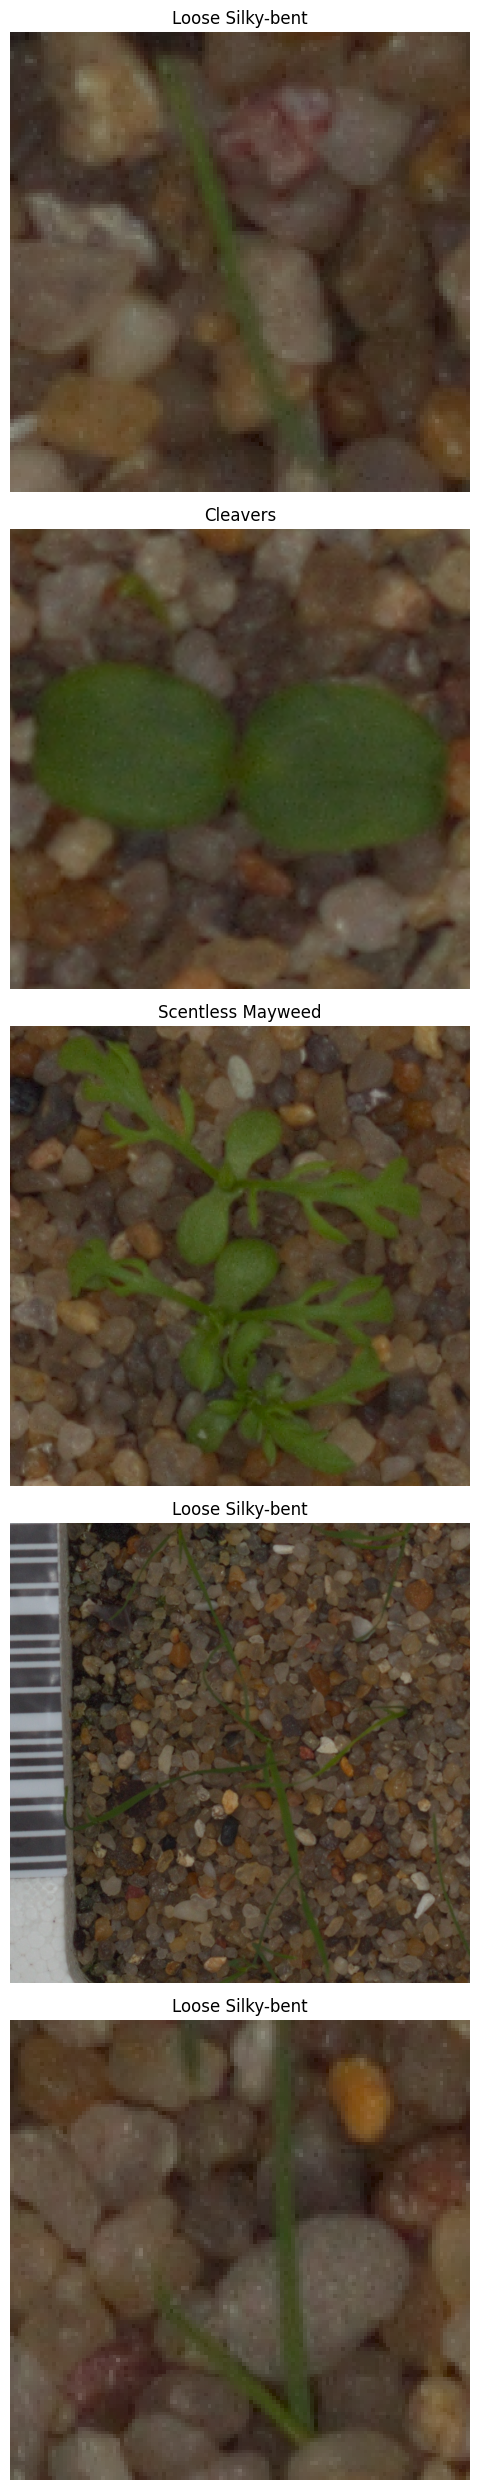

In [4]:
def display_random_images(df, n=5):
    fig, axs = plt.subplots(nrows=n, figsize=(10, n*5))
    for i in range(n):
        # Select a random row/index
        idx = random.randint(0, len(df) - 1)
        row = df.iloc[idx]
        img, species = row['image_data'], row['species']
        
        # Display the image
        if n == 1:
            axs.imshow(img)
            axs.set_title(species)
            axs.axis('off')
        else:
            axs[i].imshow(img)
            axs[i].set_title(species)
            axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
display_random_images(df, n=5)

### 2. Data preprocessing

#### A. Create X & Y from the DataFrame.

In [5]:
X = df['image_data']  # Features (images)
Y = df['species']  # Labels

#### B. Encode labels of the images.

In [7]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

#### C. Unify shape of all the images.

In [8]:
# Function to resize images
def resize_images(image_list, size=(128, 128)):
    resized_images = []
    for image in image_list:
        # Resize image and convert to RGB to ensure 3 color channels
        resized_image = image.resize(size).convert('RGB')
        resized_images.append(resized_image)
    return resized_images

# Apply resizing to all images in X
X_resized = resize_images(X)

#### D. Normalise all the images.

In [10]:
# Function to normalize images
def normalize_images(image_list):
    normalized_images = np.array([np.array(image) / 255.0 for image in image_list])
    return normalized_images

# Apply normalization to all resized images
X_normalized = normalize_images(X_resized)

### 3. Model training

#### A. Split the data into train and test data.

In [13]:
# Ensuring the shape of X is correct
# Reshape if necessary (the shape should be [num_images, height, width, channels])
if len(X_normalized.shape) < 4:
    X_normalized = X_normalized.reshape(X_normalized.shape[0], 128, 128, 3)  # Adjust based on your chosen size

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y_encoded, test_size=0.2, random_state=42)

#### B. Create new CNN architecture to train the model. 

In [15]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer: one neuron per class
])

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### C. Train the model on train data and validate on test data.

In [17]:
# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10


119/119 [==============================] - 36s 266ms/step - loss: 2.1440 - accuracy: 0.2613 - val_loss: 1.5493 - val_accuracy: 0.4632
Epoch 2/10
119/119 [==============================] - 30s 255ms/step - loss: 1.4491 - accuracy: 0.4918 - val_loss: 1.1241 - val_accuracy: 0.6084
Epoch 3/10
119/119 [==============================] - 29s 242ms/step - loss: 1.0956 - accuracy: 0.6271 - val_loss: 0.9298 - val_accuracy: 0.6989
Epoch 4/10
119/119 [==============================] - 28s 238ms/step - loss: 0.8981 - accuracy: 0.7008 - val_loss: 0.8635 - val_accuracy: 0.6937
Epoch 5/10
119/119 [==============================] - 29s 240ms/step - loss: 0.6887 - accuracy: 0.7753 - val_loss: 0.6694 - val_accuracy: 0.7600
Epoch 6/10
119/119 [==============================] - 29s 247ms/step - loss: 0.5700 - accuracy: 0.8068 - val_loss: 0.6464 - val_accuracy: 0.7811
Epoch 7/10
119/119 [==============================] - 29s 248ms/step - loss: 0.5097 - accuracy: 0.8268 - val_loss: 0.6721 - val_

#### D. Select a random image and print actual label and predicted label for the same.

In [18]:
# Select a random image from the test set
random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
random_image_expanded = np.expand_dims(random_image, axis=0)  # Model expects a batch

# Predict the label
predicted = model.predict(random_image_expanded)
predicted_label = label_encoder.inverse_transform([np.argmax(predicted)])

# Get the actual label
actual_label = label_encoder.inverse_transform([Y_test[random_index]])

1/1 [==============================] - 0s 240ms/step


Actual Label: Shepherds Purse
Predicted Label: Shepherds Purse


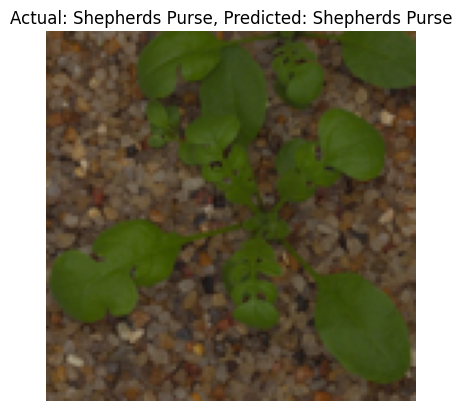

In [19]:
# Print actual and predicted labels
print(f"Actual Label: {actual_label[0]}")
print(f"Predicted Label: {predicted_label[0]}")

# Display the image
plt.imshow(random_image)
plt.title(f"Actual: {actual_label[0]}, Predicted: {predicted_label[0]}")
plt.axis('off')
plt.show()